In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download('vader_lexicon')

In [3]:
df = pd.read_csv("D:/Projects/#data/kaggle_amazon_fine_reviews/Reviews.csv")
print(df.shape[0])
df = df.head(500)
print(df.shape[0])
df.head()


568454
500


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Quick EDA

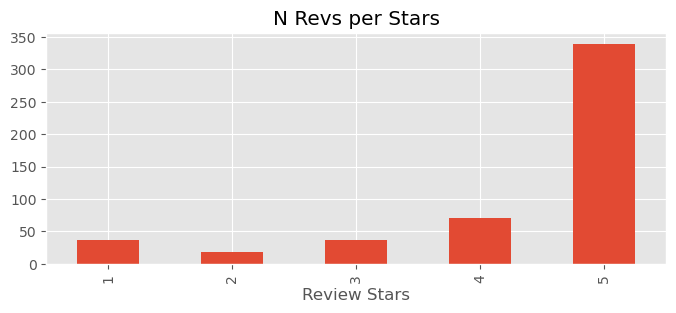

In [8]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='N Revs per Stars', 
                                            figsize=(8,3))
ax.set_xlabel("Review Stars")
plt.show()

### Basic NLTK

In [9]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [14]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [19]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

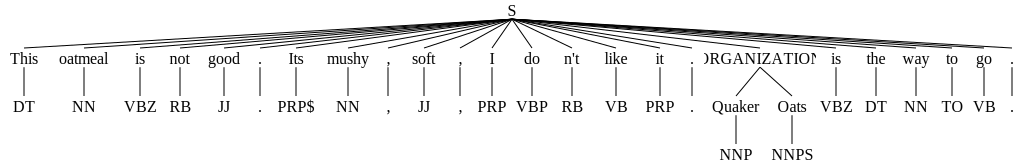

In [28]:
nltk.chunk.ne_chunk(tagged)

### VADER Sentiment Scoring

Uses "bag of words" approach:
- Stop words are removed
- each word is scored how positive/negitva/neutral and combined into a total score

Big drawback: It does not take into account the relationships between words

In [33]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [34]:
sia.polarity_scores("I am so happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [35]:
sia.polarity_scores("This is the worst thing ever!!!")

{'neg': 0.499, 'neu': 0.501, 'pos': 0.0, 'compound': -0.7163}

In [36]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [41]:
# Run polarity score on entire df
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    id = row['Id']
    res[id] = sia.polarity_scores(text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [45]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, on='Id', how='left')
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [46]:
vaders.groupby('Score')['compound'].mean().reset_index()

,Score,compound
0,1,-0.127569
1,2,0.198178
2,3,0.431411
3,4,0.655927
4,5,0.762773


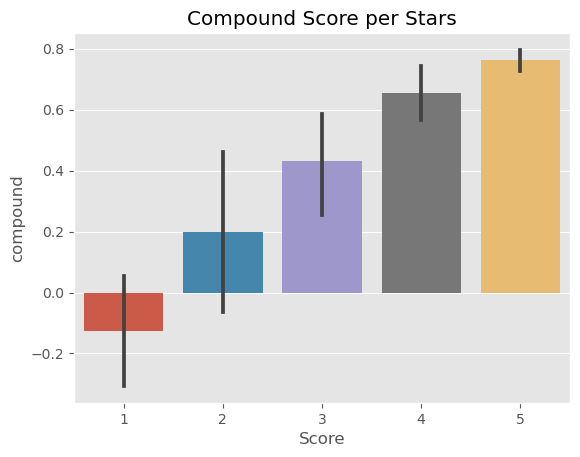

In [49]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score per Stars')
plt.show()

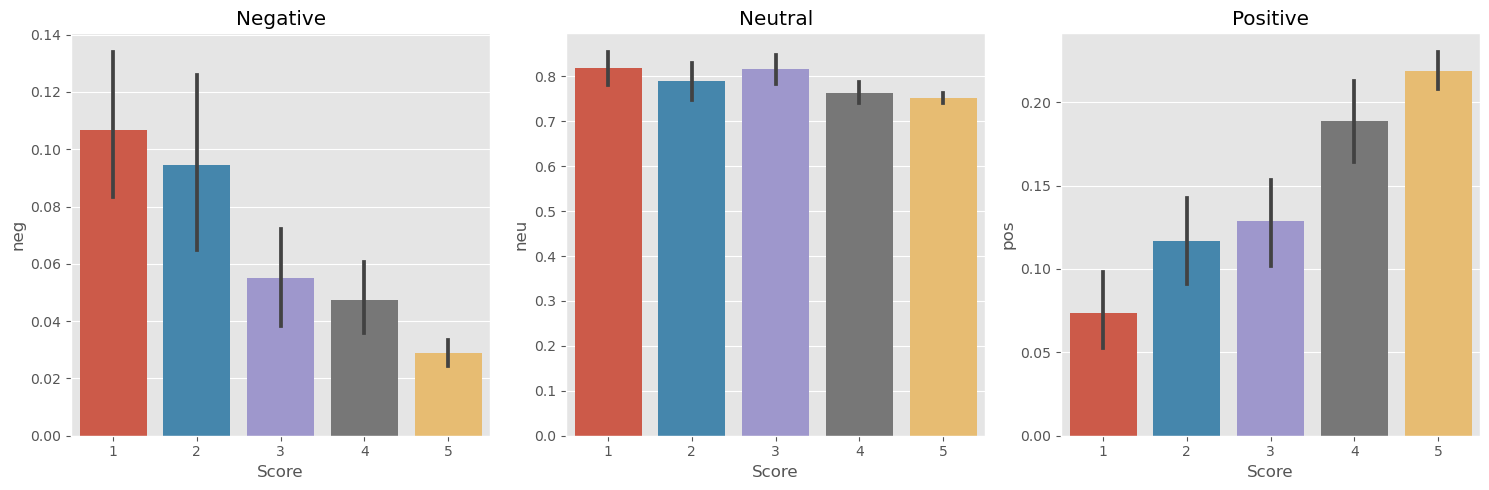

In [52]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[2])
axs[0].set_title("Negative")
axs[1].set_title("Neutral")
axs[2].set_title("Positive")
plt.tight_layout()
plt.show()